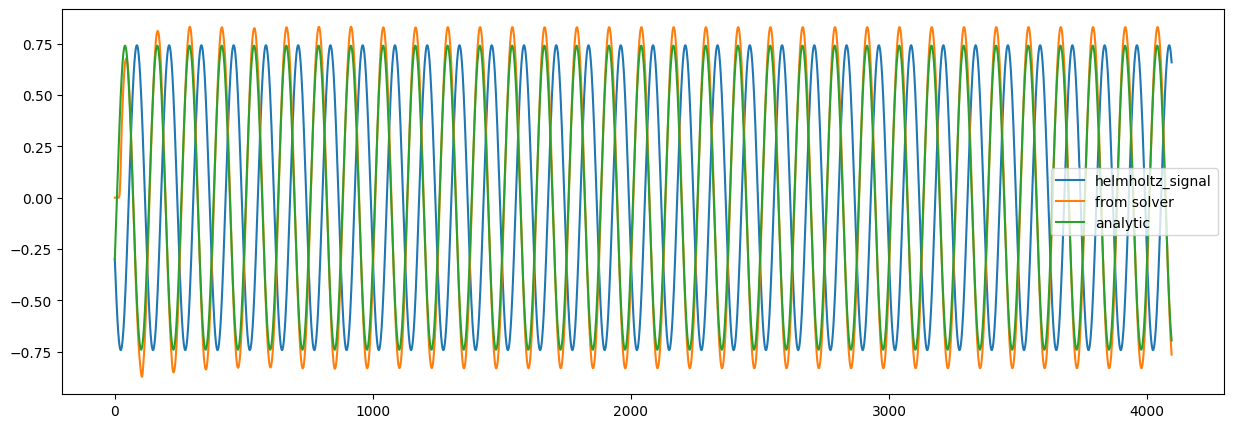

In [162]:
import numpy as np
import matplotlib.pyplot as plt

data1 = np.loadtxt('../build/helmholtz_signal.txt')
data2 = np.loadtxt('../build/pppm_signal.txt')
data3 = np.loadtxt('../build/analytic_signal.txt')

plt.figure(figsize=(15, 5))
plt.plot(data1)
plt.plot(data2)
plt.plot(data3)
plt.legend(['helmholtz_signal', 'from solver', 'analytic'])

In [163]:
from bempp.api.operators import potential, boundary
from bempp.api import GridFunction, export, function_space

import numpy as np
class ObjLoader(object):
    def __init__(self, fileName):
        self.vertices = []
        self.faces = []
        try:
            f = open(fileName)
            for line in f:
                if line[:2] == "v ":
                    vertex = list(map(float, line[1:].split()))
                    self.vertices.append(vertex)
                elif line[0] == "f":
                    line = line[1:].split()
                    face = []
                    for item in line:
                        if item.find('/') > 0:
                            item = item[:item.find('/')]
                        face.append(int(item)-1)
                    self.faces.append(face)
            f.close()
        except IOError:
            print(f'{fileName} not found.')
    
        self.vertices = np.asarray(self.vertices)
        self.faces = np.asarray(self.faces)
    
    def get_bounding_box(self):
        vertices = self.vertices
        max_bound, min_bound = vertices.max(0), vertices.min(0)
        return max_bound, min_bound

    def get_length(self):
        max_bound, min_bound = self.get_bounding_box()
        return (max_bound - min_bound).max()
        
    def normalize(self):
        vertices = self.vertices
        max_bound, min_bound = vertices.max(0), vertices.min(0)
        vertices = (vertices - (max_bound+min_bound)/2) / (max_bound - min_bound).max()
        self.vertices = vertices

    def export(self, filename):
        with open(filename, 'w') as f:
            f.write("# OBJ file\n")
            for v in self.vertices:
                f.write(f"v {v[0]:.4f} {v[1]:.4f} {v[2]:.4f}\n")
            for p in self.faces:
                f.write("f ")
                for i in p:
                    f.write(f'{i+1} ')
                f.write("\n")
mesh = ObjLoader('../assets/sphere4.obj')
mesh.normalize()
def obj_to_grid(vertices, elements):
    import bempp.api
    vertices = np.asarray(vertices)
    elements = np.asarray(elements)
    return bempp.api.Grid(vertices.T.astype(np.float64), 
                        elements.T.astype(np.uint32))

vertices = mesh.vertices
elements = mesh.faces
# stretch the mesh to 0.106667
mesh_length = 0.106667
vertices = vertices *  mesh_length / mesh.get_length()

evalue_elements = elements
grid = obj_to_grid(vertices, evalue_elements)
dp0_space = function_space(grid, "DP", 0)
p1_space = function_space(grid, "P", 1)


In [164]:
wave_number = 59.0855
def neumann_coeff(r):
    ikr = 1j * wave_number * r
    return -np.exp(-ikr) / (4 * np.pi * r * r) * (1 + ikr)
def dirichlet_coeff(r):
    ikr = 1j * wave_number * r
    return np.exp(-ikr) / (4 * np.pi * r)

r = np.ones(len(evalue_elements))*mesh_length/2
neumann_fun = GridFunction(dp0_space, coefficients=neumann_coeff(r))
dirichlet_fun = GridFunction(dp0_space, coefficients=dirichlet_coeff(r))

point = np.array([[0.107558, 0.0, 0.0]])
potential_single = potential.helmholtz.single_layer(dp0_space, point.T, wave_number, precision="double",device_interface="numba")
potential_double = potential.helmholtz.double_layer(dp0_space, point.T, wave_number, precision="double",device_interface="numba")
dirichlet = potential_double * dirichlet_fun 
print(dirichlet[0])
print(dirichlet_coeff(0.107558))

[0.7361462+0.04590775j]
(0.7379430610852344-0.05317413113471619j)
